<a href="https://colab.research.google.com/github/Tee-Sarun/DADS6003_ML_Final_Project/blob/main/Final_Project_TF-IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To install a Python library in Colab, prefix the `pip install` command with an exclamation mark (`!`) in a code cell. For example, to install `requests`, you would run:

In [4]:
!pip install requests

You can then import and use the library in subsequent cells:

In [5]:
import requests
print("Requests library installed and imported successfully!")

Requests library installed and imported successfully!


In [6]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

# Import Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# =========================================
# 1. ฟังก์ชันสำหรับเตรียมข้อมูล (Text Preprocessing & Label Encoding)
# =========================================
def preprocess_text(text):
    """
    ฟังก์ชันทำความสะอาดข้อความเบื้องต้น
    """
    if not isinstance(text, str): return ""
    # 1. แปลงเป็นตัวพิมพ์เล็ก
    text = text.lower()
    # 2. ลบตัวเลข
    text = re.sub(r'\d+', '', text)
    # 3. ลบเครื่องหมายวรรคตอนและอักขระพิเศษ
    text = re.sub(r'[^\w\s]', '', text)
    # 4. ลบช่องว่างส่วนเกิน
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def prepare_data(df_input):
    df = df_input.copy()

    # --- ส่วนที่เพิ่มเข้ามา: แปลง Label จากข้อความให้เป็นตัวเลข ---
    print("  -> กำลังแปลง Label 'Legitimate'/'Phishing' เป็น 0/1...")
    # สร้าง dict สำหรับ mapping
    label_mapping = {'Legitimate': 0, 'Phishing': 1}
    # ใช้ .map() เพื่อแปลงค่า
    df['Label'] = df['Label'].map(label_mapping)

    # ตรวจสอบว่ามี Label ไหนที่ map ไม่ได้หรือไม่ (จะเป็น NaN)
    if df['Label'].isna().any():
        print("Warning: พบ Label ที่ไม่ใช่ 'Legitimate' หรือ 'Phishing' แถวเหล่านี้จะถูกลบ")
        df.dropna(subset=['Label'], inplace=True)

    # แปลงให้เป็น integer อย่างชัดเจน
    df['Label'] = df['Label'].astype(int)
    # -----------------------------------------------------------

    # รวม Subject และ Body
    df['Full_Text'] = df['Subject'].fillna('') + " " + df['Body'].fillna('')

    # ทำความสะอาดข้อความ
    df['Processed_Text'] = df['Full_Text'].apply(preprocess_text)

    # ลบแถวที่ไม่มีข้อความเหลืออยู่เลยหลังจากการ process
    df = df[df['Processed_Text'] != '']

    return df

# =========================================
# 2. โหลดและเตรียมข้อมูล
# =========================================
train_url = "https://raw.githubusercontent.com/Tee-Sarun/DADS6003_ML_Final_Project/main/train.csv"
test_url = "https://raw.githubusercontent.com/Tee-Sarun/DADS6003_ML_Final_Project/main/test.csv"

print("กำลังโหลดข้อมูล...")
try:
    train_df_raw = pd.read_csv(train_url)
    test_df_raw = pd.read_csv(test_url)
    # ลบช่องว่างในชื่อคอลัมน์
    train_df_raw.columns = train_df_raw.columns.str.strip()
    test_df_raw.columns = test_df_raw.columns.str.strip()
    print(f"โหลดสำเร็จ! ตัวอย่าง Label เดิม: {train_df_raw['Label'].unique()}")
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

print("\nกำลังเตรียมข้อมูล Train (Text Preprocessing & Label Encoding)...")
train_df_processed = prepare_data(train_df_raw)
print("\nกำลังเตรียมข้อมูล Test (Text Preprocessing & Label Encoding)...")
test_df_processed = prepare_data(test_df_raw)

# แยก Features (X) และ Target (y)
X_train_text = train_df_processed['Processed_Text']
y_train = train_df_processed['Label'] # ตอนนี้ y เป็น 0, 1 แล้ว

X_test_text = test_df_processed['Processed_Text']
y_test = test_df_processed['Label'] # ตอนนี้ y เป็น 0, 1 แล้ว

print(f"\nตัวอย่าง Label หลังแปลง: {y_train.unique()}")
print(f"ขนาดข้อมูลพร้อมเทรน: {len(X_train_text)}, ขนาดข้อมูลเทส: {len(X_test_text)}")

# =========================================
# 3. กำหนด Pipeline, Models และ Parameter Grids
# =========================================
# ใช้ StratifiedKFold เพื่อรักษาสัดส่วนของ Class 0 และ 1
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# TF-IDF Vectorizer (จำกัด max_features เพื่อความเร็วในการทดสอบ)
tfidf = TfidfVectorizer(stop_words='english', max_features=3000)

models_config = {
    'LogisticRegression': {
        'model': LogisticRegression(solver='liblinear', random_state=42),
        'params': {
            'tfidf__ngram_range': [(1, 1), (1, 2)],
            'clf__C': [0.1, 1, 10]
        }
    },
    'SVM': {
        'model': SVC(random_state=42),
        'params': {
            'tfidf__ngram_range': [(1, 1)],
            'clf__C': [1, 10],
            'clf__kernel': ['linear'] # ใช้ Linear kernel ก็เพียงพอและเร็วกว่าสำหรับ Text
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            # ลด grid ลงเล็กน้อยเพื่อให้รันเสร็จเร็วขึ้น
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [None, 20]
        }
    },
    'XGBoost': {
        # objective='binary:logistic' ต้องการ y เป็น 0,1 เท่านั้น
        'model': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', objective='binary:logistic'),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.1],
            'clf__max_depth': [3, 5]
        }
    }
}

# =========================================
# 4. Main Loop: Grid Search และประเมินผล
# =========================================
results = {}

print("\n" + "="*50)
print("เริ่มต้นการเทรนและปรับจูนโมเดล (NLP Pipeline)")
print("="*50)

for model_name, config in models_config.items():
    print(f"\n>>> กำลังประมวลผล: {model_name}...")

    # สร้าง Pipeline
    pipeline = Pipeline([
        ('tfidf', tfidf),
        ('clf', config['model'])
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=config['params'],
        cv=cv_strategy,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    # เทรนโมเดล (ตอนนี้ y_train เป็นตัวเลขแล้ว จะไม่ error)
    try:
        grid_search.fit(X_train_text, y_train)

        best_model_pipeline = grid_search.best_estimator_
        y_pred = best_model_pipeline.predict(X_test_text)

        results[model_name] = {
            'best_params': grid_search.best_params_,
            'accuracy': accuracy_score(y_test, y_pred),
            'report': classification_report(y_test, y_pred, target_names=['Legitimate (0)', 'Phishing (1)']),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        print(f"  -> Best Params: {grid_search.best_params_}")
        print(f"  -> Test Accuracy: {results[model_name]['accuracy']:.4f}")

    except Exception as e:
        print(f"Error training {model_name}: {e}")


# =========================================
# 5. สรุปผล (Final Results)
# =========================================
print("\n" + "="*60)
print("สรุปผลการประเมินประสิทธิภาพแต่ละ Model บน Test Set")
print("="*60)

if results:
    best_model_name = max(results, key=lambda k: results[k]['accuracy'])
    for model_name, result in results.items():
        marker = " <<< BEST MODEL" if model_name == best_model_name else ""
        print(f"\n--- Model: {model_name}{marker} ---")
        print(f"Accuracy: {result['accuracy']:.4f}")
        print("Classification Report:\n", result['report'])
        print("Confusion Matrix [[TN (Legit), FP], [FN, TP (Phish)]]:\n", result['confusion_matrix'])
        print("-" * 40)
    print(f"\nสรุป: โมเดลที่ให้ค่า Accuracy สูงที่สุดบน Test Set คือ {best_model_name} ด้วยค่า Accuracy: {results[best_model_name]['accuracy']:.4f}")
else:
    print("ไม่มีผลลัพธ์เนื่องจากเกิดข้อผิดพลาดในการเทรน")

กำลังโหลดข้อมูล...
โหลดสำเร็จ! ตัวอย่าง Label เดิม: ['Legitimate' 'Phishing']

กำลังเตรียมข้อมูล Train (Text Preprocessing & Label Encoding)...
  -> กำลังแปลง Label 'Legitimate'/'Phishing' เป็น 0/1...

กำลังเตรียมข้อมูล Test (Text Preprocessing & Label Encoding)...
  -> กำลังแปลง Label 'Legitimate'/'Phishing' เป็น 0/1...

ตัวอย่าง Label หลังแปลง: [0 1]
ขนาดข้อมูลพร้อมเทรน: 100, ขนาดข้อมูลเทส: 26

เริ่มต้นการเทรนและปรับจูนโมเดล (NLP Pipeline)

>>> กำลังประมวลผล: LogisticRegression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
  -> Best Params: {'clf__C': 0.1, 'tfidf__ngram_range': (1, 1)}
  -> Test Accuracy: 0.7692

>>> กำลังประมวลผล: SVM...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
  -> Best Params: {'clf__C': 1, 'clf__kernel': 'linear', 'tfidf__ngram_range': (1, 1)}
  -> Test Accuracy: 0.9615

>>> กำลังประมวลผล: RandomForest...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  -> Best Params: {'clf__max_depth': None, 'clf__n_estimators': 2

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:43:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  -> Best Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100}
  -> Test Accuracy: 0.8077

สรุปผลการประเมินประสิทธิภาพแต่ละ Model บน Test Set

--- Model: LogisticRegression ---
Accuracy: 0.7692
Classification Report:
                 precision    recall  f1-score   support

Legitimate (0)       0.73      0.85      0.79        13
  Phishing (1)       0.82      0.69      0.75        13

      accuracy                           0.77        26
     macro avg       0.78      0.77      0.77        26
  weighted avg       0.78      0.77      0.77        26

Confusion Matrix [[TN (Legit), FP], [FN, TP (Phish)]]:
 [[11  2]
 [ 4  9]]
----------------------------------------

--- Model: SVM <<< BEST MODEL ---
Accuracy: 0.9615
Classification Report:
                 precision    recall  f1-score   support

Legitimate (0)       1.00      0.92      0.96        13
  Phishing (1)       0.93      1.00      0.96        13

      accuracy                           0.96      

## Visualize Model Performance

### Subtask:
สร้างแผนภูมิแท่ง (bar chart) เพื่อเปรียบเทียบ Accuracy, Precision, Recall และ F1-score สำหรับทุกโมเดลที่ได้รับการฝึกอบรม โดยจะมี Legend และป้ายกำกับที่เหมาะสมเพื่อความชัดเจน

**Reasoning**:
To provide a clear visual comparison of model performance, I will create a bar chart. This involves extracting the relevant metrics (Accuracy, Precision_Phishing, Recall_Phishing, F1_Score_Phishing) from the `results` dictionary, organizing them into a pandas DataFrame, melting the DataFrame for easier plotting, and then using `seaborn` and `matplotlib` to generate the bar plot with appropriate labels and title.

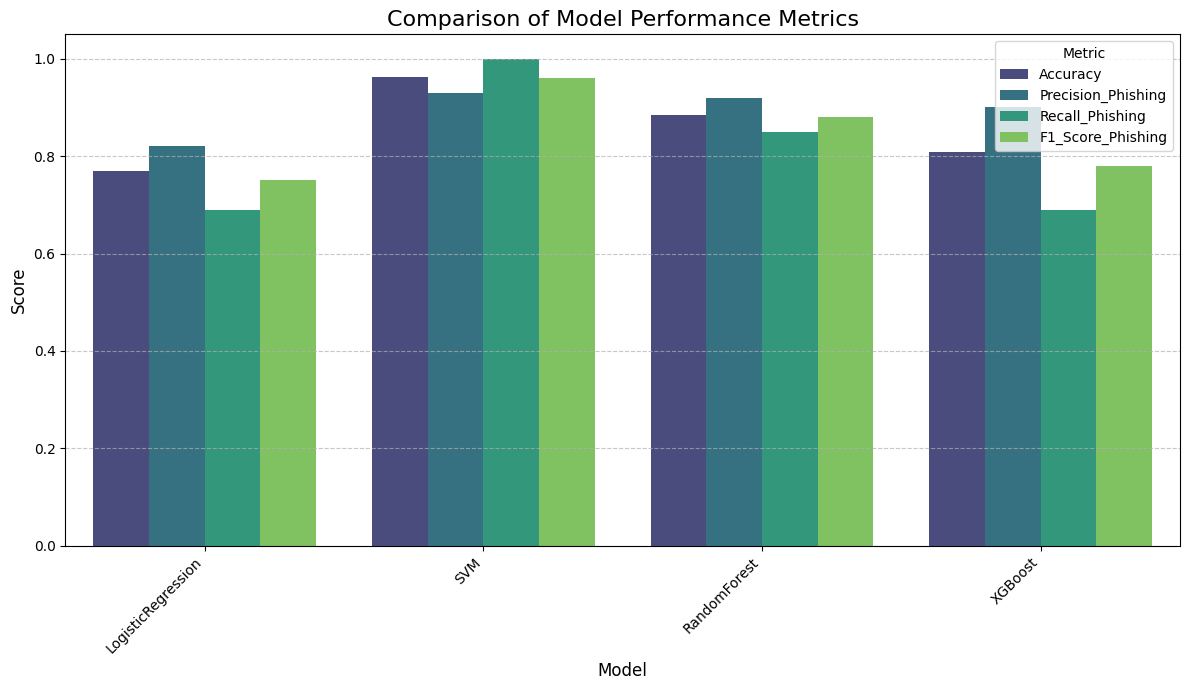

In [8]:
# Extract metrics for all models for 'Phishing' class (label 1)
model_names = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

for model_name, result in results.items():
    model_names.append(model_name)
    accuracies.append(result['accuracy'])

    # Parse classification report for 'Phishing (1)' metrics
    report_lines = result['report'].split('\n')
    phishing_line = None
    for line in report_lines:
        if 'Phishing (1)' in line:
            phishing_line = line
            break

    if phishing_line:
        # Example line: '  Phishing (1)       0.90      0.69      0.78        13'
        # parts[0] is 'Phishing', parts[1] is '(1)'
        # Correct indices are parts[2] for precision, parts[3] for recall, parts[4] for f1
        parts = phishing_line.split()
        # Ensure parts has enough elements before accessing
        if len(parts) >= 5:
            precision = float(parts[2])
            recall = float(parts[3])
            f1 = float(parts[4])
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
        else:
            # Handle cases where parsing fails, e.g., append NaN or 0
            precisions.append(0.0)
            recalls.append(0.0)
            f1_scores.append(0.0)
    else:
        precisions.append(0.0)
        recalls.append(0.0)
        f1_scores.append(0.0)

# Create a DataFrame for visualization
performance_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision_Phishing': precisions,
    'Recall_Phishing': recalls,
    'F1_Score_Phishing': f1_scores
})

# Melt the DataFrame for easier plotting with seaborn
performance_melted = performance_df.melt(
    id_vars='Model',
    var_name='Metric',
    value_name='Value'
)

# Define the order of metrics to be displayed
metric_order = ['Accuracy', 'Precision_Phishing', 'Recall_Phishing', 'F1_Score_Phishing']
performance_melted['Metric'] = pd.Categorical(performance_melted['Metric'], categories=metric_order, ordered=True)

plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Value', hue='Metric', data=performance_melted, palette='viridis')
plt.title('Comparison of Model Performance Metrics', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.05) # Scores are usually between 0 and 1
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Final Summary and Best Model Identification

### Subtask:
สรุปผลการวิเคราะห์ทั้งหมด รวมถึงโมเดลที่ดีที่สุดสำหรับแต่ละเมตริก และให้ข้อมูลเชิงลึกจากผลการประเมิน

**Reasoning**:
Now that all evaluation metrics have been extracted and visualized, the final step is to provide a comprehensive summary. This includes identifying the best-performing model for each key metric (Accuracy, Precision_Phishing, Recall_Phishing, F1_Score_Phishing) and presenting the full performance DataFrame. This will give a clear conclusion to the model comparison analysis.

In [9]:
print("\n" + "="*60)
print("สรุปผลการประเมินประสิทธิภาพแต่ละ Model บน Test Set")
print("="*60)

if results:
    # Identify best model for each metric
    best_accuracy_model = performance_df.loc[performance_df['Accuracy'].idxmax()]
    best_precision_model = performance_df.loc[performance_df['Precision_Phishing'].idxmax()]
    best_recall_model = performance_df.loc[performance_df['Recall_Phishing'].idxmax()]
    best_f1_model = performance_df.loc[performance_df['F1_Score_Phishing'].idxmax()]

    print(f"Highest Accuracy: {best_accuracy_model['Model']} ({best_accuracy_model['Accuracy']:.4f})")
    print(f"Highest Precision (Phishing): {best_precision_model['Model']} ({best_precision_model['Precision_Phishing']:.4f})")
    print(f"Highest Recall (Phishing): {best_recall_model['Model']} ({best_recall_model['Recall_Phishing']:.4f})")
    print(f"Highest F1-Score (Phishing): {best_f1_model['Model']} ({best_f1_model['F1_Score_Phishing']:.4f})")

    print("\nFull Performance Summary:")
    print(performance_df.to_string(index=False))

else:
    print("ไม่มีผลลัพธ์เนื่องจากเกิดข้อผิดพลาดในการเทรน")


สรุปผลการประเมินประสิทธิภาพแต่ละ Model บน Test Set
Highest Accuracy: SVM (0.9615)
Highest Precision (Phishing): SVM (0.9300)
Highest Recall (Phishing): SVM (1.0000)
Highest F1-Score (Phishing): SVM (0.9600)

Full Performance Summary:
             Model  Accuracy  Precision_Phishing  Recall_Phishing  F1_Score_Phishing
LogisticRegression  0.769231                0.82             0.69               0.75
               SVM  0.961538                0.93             1.00               0.96
      RandomForest  0.884615                0.92             0.85               0.88
           XGBoost  0.807692                0.90             0.69               0.78
